In [1]:
import os
import zipfile

# Unzipping the dataset
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Checking the folders (categories) and counting the number of images in each category
categories = os.listdir('/content/dataset')
image_counts = {category: len(os.listdir(f'/content/dataset/{category}')) for category in categories}

image_counts


{'__MACOSX': 1, 'dataset': 5}

In [11]:
!rm /content/dataset/dataset/.DS_Store

In [12]:
# Checking the folders (categories) inside the "dataset" folder
categories_path = '/content/dataset/dataset'
categories = os.listdir(categories_path)
image_counts = {category: len(os.listdir(f'{categories_path}/{category}')) for category in categories}

image_counts

# Filtering out non-directory entries and re-checking the image counts
categories = [category for category in categories if os.path.isdir(f'{categories_path}/{category}')]
image_counts = {category: len(os.listdir(f'{categories_path}/{category}')) for category in categories}
image_counts


{'automobile': 5000, 'truck': 5000, 'ship': 5000, 'airplane': 5000}

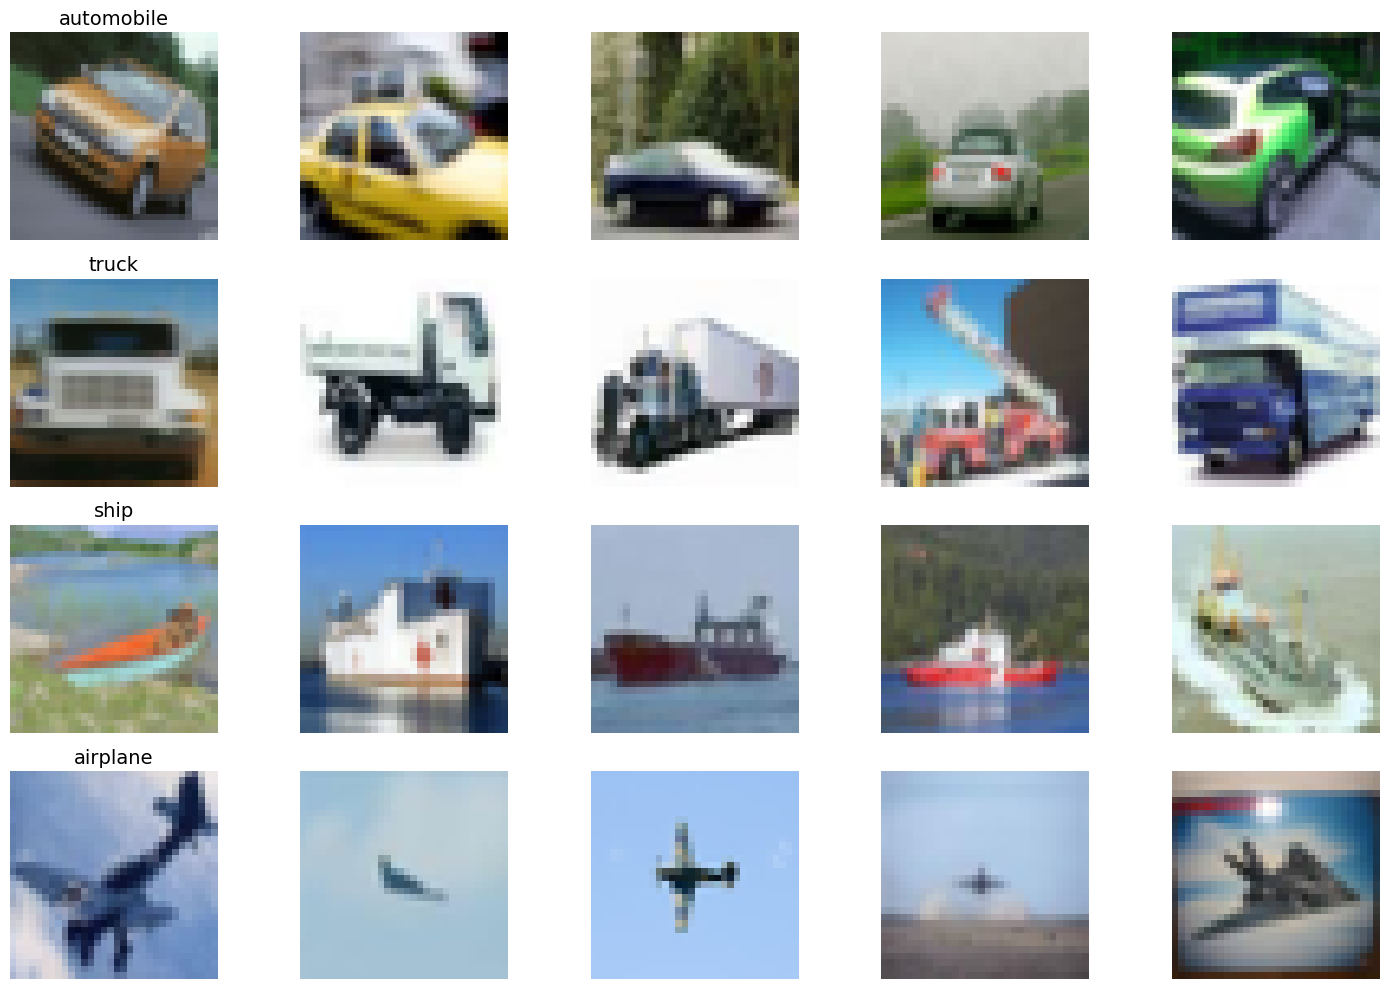

In [13]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Function to display sample images from each category
def display_sample_images(base_path, categories, num_samples=5):
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 10))

    for i, category in enumerate(categories):
        sample_images = random.sample(os.listdir(f'{base_path}/{category}'), num_samples)

        for j, image_file in enumerate(sample_images):
            image_path = f'{base_path}/{category}/{image_file}'
            image = Image.open(image_path)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category, fontsize=14)

    plt.tight_layout()
    plt.show()

display_sample_images(categories_path, categories)


In [14]:
# Function to collect image dimensions from each category
def collect_image_dimensions(base_path, categories):
    dimensions = []
    for category in categories:
        for image_file in os.listdir(f'{base_path}/{category}'):
            image_path = f'{base_path}/{category}/{image_file}'
            image = Image.open(image_path)
            dimensions.append(image.size)
    return dimensions

# Collecting dimensions of the images
image_dimensions = collect_image_dimensions(categories_path, categories)

# Extracting width and height from the dimensions
widths, heights = zip(*image_dimensions)

# Displaying some statistics about the image dimensions
min_width, max_width, min_height, max_height = min(widths), max(widths), min(heights), max(heights)
min_width, max_width, min_height, max_height


(32, 32, 32, 32)

In [15]:
# Function to determine if an image is grayscale or colored
def is_grayscale(image):
    return len(image.getbands()) == 1

# Checking color status for a sample of images
sample_size = 100
sample_images = random.sample(image_dimensions, sample_size)
color_status = [is_grayscale(Image.open(f'{categories_path}/{category}/{image_file}')) for category in categories for image_file in random.sample(os.listdir(f'{categories_path}/{category}'), sample_size//len(categories))]

# Counting grayscale and colored images
grayscale_count = sum(color_status)
colored_count = sample_size - grayscale_count

grayscale_count, colored_count


(0, 100)

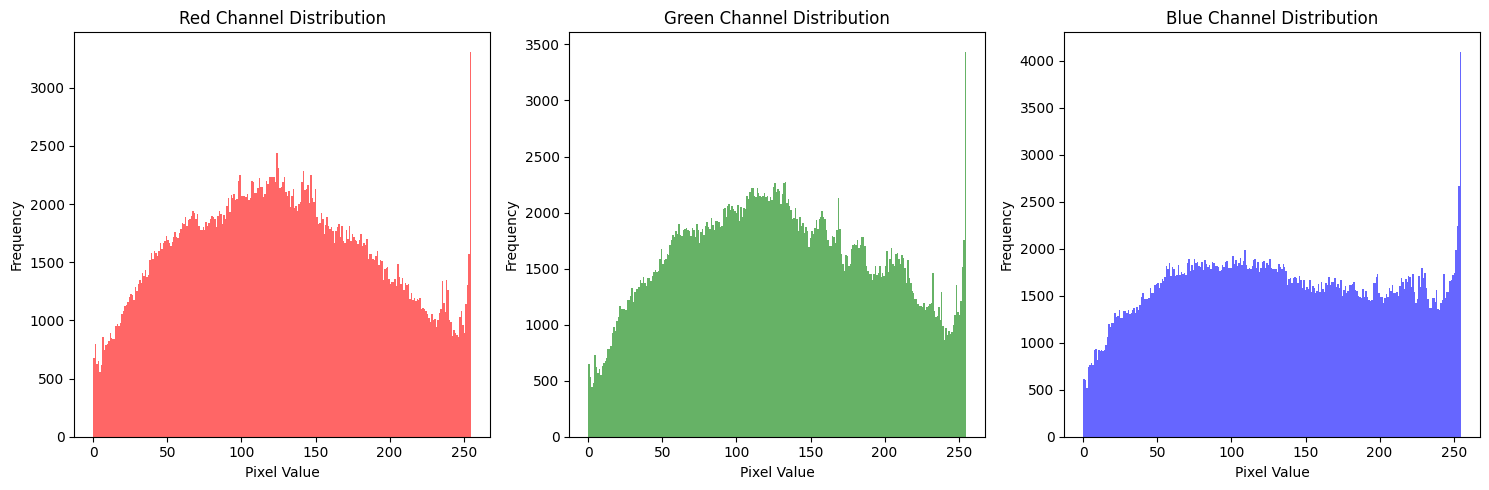

In [16]:
import numpy as np

# Function to plot RGB distribution for a sample of images
def plot_rgb_distribution(base_path, categories, num_samples=100):
    # RGB channels accumulators
    red_vals, green_vals, blue_vals = [], [], []

    # Randomly sampling images
    sample_images = [random.choice(os.listdir(f'{base_path}/{category}')) for category in categories for _ in range(num_samples // len(categories))]

    for category in categories:
        for image_file in sample_images:
            image_path = f'{base_path}/{category}/{image_file}'
            image = Image.open(image_path)
            if not is_grayscale(image):  # Only considering colored images
                r, g, b = np.array(image).T
                red_vals.extend(r.flatten())
                green_vals.extend(g.flatten())
                blue_vals.extend(b.flatten())

    # Plotting RGB distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(red_vals, bins=256, color='red', alpha=0.6)
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(green_vals, bins=256, color='green', alpha=0.6)
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(blue_vals, bins=256, color='blue', alpha=0.6)
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_rgb_distribution(categories_path, categories)


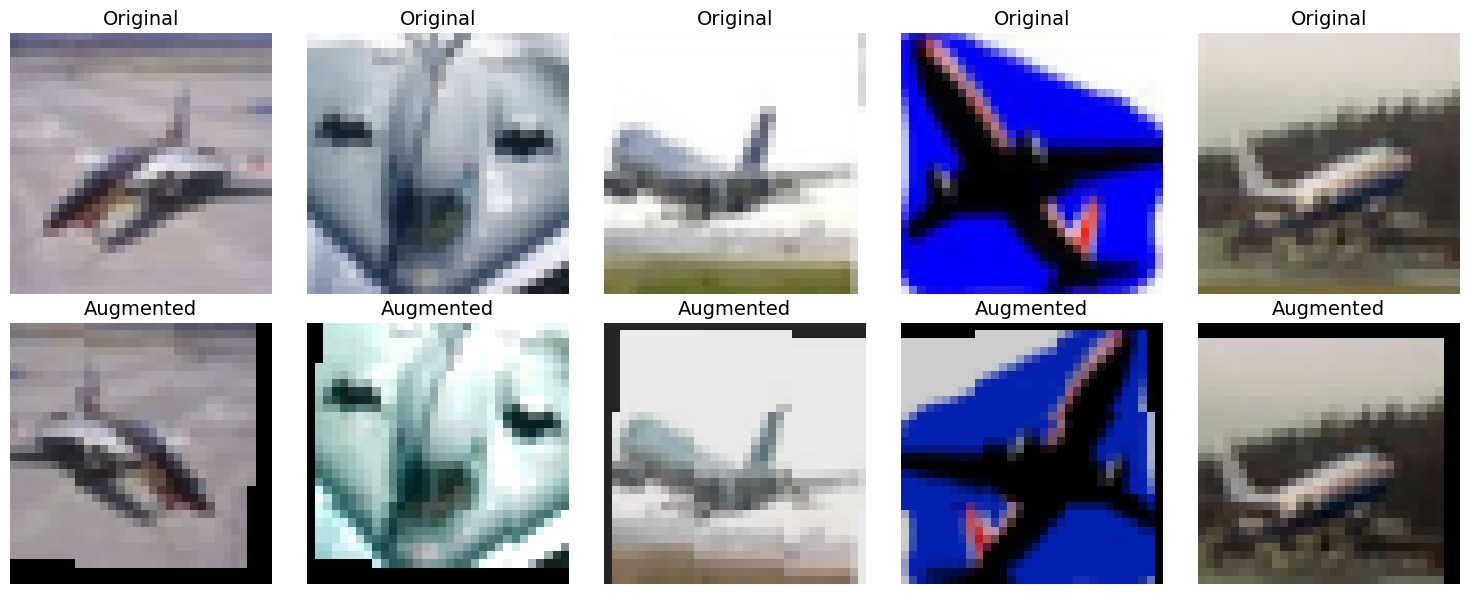

In [17]:
from torchvision import transforms

# Data augmentation transformations
transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Visualizing augmented images for demonstration
def visualize_augmentation(base_path, category, transform, num_samples=5):
    sample_images = random.sample(os.listdir(f'{base_path}/{category}'), num_samples)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i, image_file in enumerate(sample_images):
        image_path = f'{base_path}/{category}/{image_file}'
        image = Image.open(image_path)

        # Original image
        axes[0, i].imshow(image)
        axes[0, i].axis('off')
        axes[0, i].set_title('Original', fontsize=14)

        # Augmented image
        augmented_image = transform(image)
        axes[1, i].imshow(augmented_image)
        axes[1, i].axis('off')
        axes[1, i].set_title('Augmented', fontsize=14)

    plt.tight_layout()
    plt.show()

# Demonstrating augmentation using airplane category
visualize_augmentation(categories_path, 'airplane', transform_augment)


In [18]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets
train_data, temp_data = {}, {}
val_data, test_data = {}, {}

for category in categories:
    images = os.listdir(f'{categories_path}/{category}')
    train, temp = train_test_split(images, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    train_data[category] = train
    val_data[category] = val
    test_data[category] = test

# Checking the number of images in each split for each category
train_counts = {category: len(images) for category, images in train_data.items()}
val_counts = {category: len(images) for category, images in val_data.items()}
test_counts = {category: len(images) for category, images in test_data.items()}

train_counts, val_counts, test_counts


({'automobile': 4000, 'truck': 4000, 'ship': 4000, 'airplane': 4000},
 {'automobile': 500, 'truck': 500, 'ship': 500, 'airplane': 500},
 {'automobile': 500, 'truck': 500, 'ship': 500, 'airplane': 500})

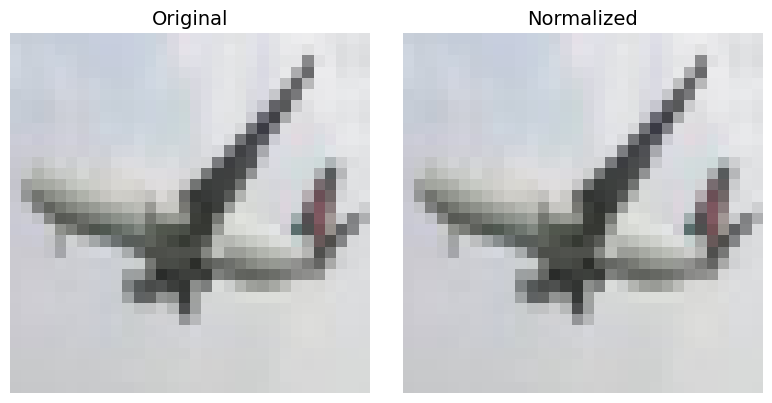

In [19]:
# Data normalization transformation
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Visualizing normalization for demonstration
def visualize_normalization(base_path, category, transform):
    image_file = random.choice(os.listdir(f'{base_path}/{category}'))
    image_path = f'{base_path}/{category}/{image_file}'
    image = Image.open(image_path)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('Original', fontsize=14)

    # Normalized image
    normalized_image = transform(image).permute(1, 2, 0)  # Changing from CxHxW to HxWxC for visualization
    axes[1].imshow(normalized_image.numpy() * 0.5 + 0.5)  # De-normalizing for visualization
    axes[1].axis('off')
    axes[1].set_title('Normalized', fontsize=14)

    plt.tight_layout()
    plt.show()

# Demonstrating normalization using airplane category
visualize_normalization(categories_path, 'airplane', transform_normalize)


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data, base_path, categories, transform=None):
        self.data = data
        self.base_path = base_path
        self.categories = categories
        self.transform = transform
        self.filepaths = []
        self.labels = []

        for label, category in enumerate(categories):
            for image_file in data[category]:
                self.filepaths.append(f'{base_path}/{category}/{image_file}')
                self.labels.append(label)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image_path = self.filepaths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Creating datasets for training, validation, and test
train_dataset = CustomImageDataset(train_data, categories_path, categories, transform=transforms.Compose([transform_augment, transform_normalize]))
val_dataset = CustomImageDataset(val_data, categories_path, categories, transform=transform_normalize)
test_dataset = CustomImageDataset(test_data, categories_path, categories, transform=transform_normalize)

# Checking the length of each dataset
len(train_dataset), len(val_dataset), len(test_dataset)


(16000, 2000, 2000)

In [21]:
# Creating dataloaders for the datasets
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Checking the number of batches in each dataloader
len(train_loader), len(val_loader), len(test_loader)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(250, 32, 32)

In [22]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [23]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = x.view(-1, 64 * 4 * 4)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [24]:
model = SimpleCNN(num_classes=4)


In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [26]:
num_epochs = 25
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate average training loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/25], Train Loss: 1.1144, Val Loss: 0.8482, Val Accuracy: 64.50%
Epoch [2/25], Train Loss: 0.8955, Val Loss: 0.6950, Val Accuracy: 72.20%
Epoch [3/25], Train Loss: 0.7628, Val Loss: 0.5608, Val Accuracy: 78.80%
Epoch [4/25], Train Loss: 0.6756, Val Loss: 0.5042, Val Accuracy: 80.75%
Epoch [5/25], Train Loss: 0.6147, Val Loss: 0.4788, Val Accuracy: 81.80%
Epoch [6/25], Train Loss: 0.5724, Val Loss: 0.4214, Val Accuracy: 84.50%
Epoch [7/25], Train Loss: 0.5352, Val Loss: 0.4302, Val Accuracy: 83.60%
Epoch [8/25], Train Loss: 0.5155, Val Loss: 0.3903, Val Accuracy: 85.90%
Epoch [9/25], Train Loss: 0.4890, Val Loss: 0.3779, Val Accuracy: 85.60%
Epoch [10/25], Train Loss: 0.4720, Val Loss: 0.3921, Val Accuracy: 86.10%
Epoch [11/25], Train Loss: 0.4628, Val Loss: 0.3769, Val Accuracy: 86.45%
Epoch [12/25], Train Loss: 0.4324, Val Loss: 0.3435, Val Accuracy: 87.35%
Epoch [13/25], Train Loss: 0.4239, Val Loss: 0.3322, Val Accuracy: 87.65%
Epoch [14/25], Train Loss: 0.4122, Val Loss: 0.

In [27]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 88.70%


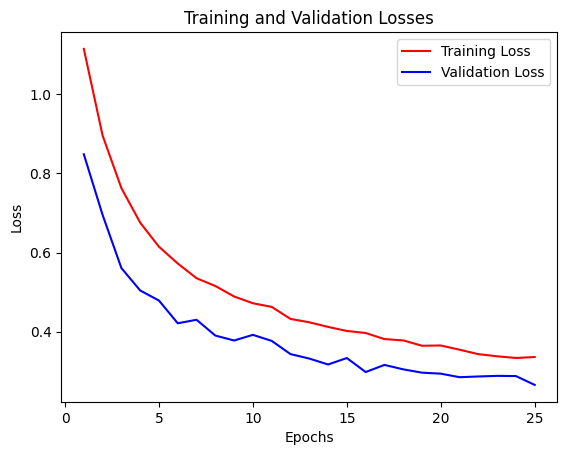

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, 26)
plt.plot(epochs, train_losses, 'r', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
torch.save(model.state_dict(), 'model_checkpoint.pth')


In [30]:
model = SimpleCNN(num_classes=4)
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval()  # Set the model to evaluation mode


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [35]:
# Train multiple CNN models
models = [SimpleCNN(num_classes=4) for _ in range(5)]

# ... Training loop for each model ...

# For prediction
def ensemble_predict(models, input_data):
    model_outputs = [model(input_data) for model in models]
    avg_output = torch.stack(model_outputs).mean(0)
    return avg_output.argmax(dim=1)
